# Jorge - Test notebook

## Data processing

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler

train = pd.read_csv('../data/train.csv',header=0)

train['time'] = pd.to_datetime(train['time'], format='%H:%M:%S')
train['hour'] = train.time.apply(lambda x : x.hour)
train['time_min'] = train['time'].dt.hour * 60 + train['time'].dt.minute

def actual_time(df, col_var):
    df[['hours', 'minutes']] = df[col_var].str.extract('(-?\d+):(\d+)')
    df['time_diff'] = df['hours'].astype(int) * 60 - df['minutes'].astype(int)
    
    # Calculate actual time in minutes for each bg measurement
    df['actual_time'] = df['time_min'] + df['time_diff']
        
    df = df.drop(columns=['hours', 'minutes', 'time_diff'])
    
    return df

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2r/vz71dl552fd4t6lk1z7s6_bh0000gn/T/ipykernel_28828/3788638225.py:16: SyntaxWarning: invalid escape sequence '\d'
  df[['hours', 'minutes']] = df[col_var].str.extract('(-?\d+):(\d+)')
/var/folders/2r/vz71dl552fd4t6lk1z7s6_bh0000gn/T/ipykernel_28828/3788638225.py:9: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('../data/train.csv',header=0)


In [117]:
ins_columns = [col for col in train.columns if col.startswith('insulin')]
ins_df = pd.melt(train, id_vars=['id', 'time_min'], value_vars=ins_columns, var_name='ins_time', value_name='ins_value')
ins_df = actual_time(ins_df, 'ins_time')

nan_counts = ins_df.groupby('id').agg({
    'ins_value': [('total', 'count'), ('nan_count', lambda x: x.isna().sum())]
}).reset_index()

nan_counts.columns = ['id', 'total_count', 'nan_count']

nan_counts = nan_counts[nan_counts['total_count'] == 0]

In [118]:
# Remove the lines with full insulin NaNs
rows_to_drop = train[train['id'].isin(nan_counts['id'])].index

train_new = train.drop(index=rows_to_drop)

In [119]:
bg_columns = [col for col in train_new.columns if col.startswith('bg-')]
bg_df = pd.melt(train_new, id_vars=['id', 'time_min'], value_vars=bg_columns, var_name='time', value_name='value')
bg_df = actual_time(bg_df, 'time')

def fill_na_values(group):
    # For the remaining NA values, use the mean of adjacent non-NA values
    group['value'] = group['value'].interpolate(method='linear')
    
    # # Backward fill the first NA values
    group['value'] = group['value'].bfill()
    # Forward fill the last NA values
    group['value'] = group['value'].ffill()
    
    return group

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    bg_df = bg_df.groupby('id').apply(fill_na_values).reset_index(drop=True)
    
scaler = MinMaxScaler()
bg_df['value'] = scaler.fit_transform(bg_df[['value']])


In [120]:

bg_df.drop(["time_min", "time"], axis = 1, inplace = True)
bg_df.head()

,id,value,actual_time
0,p01_0,0.289062,15
1,p01_0,0.289062,20
2,p01_0,0.289062,25
3,p01_0,0.290365,30
4,p01_0,0.291667,35


In [121]:
ins_columns = [col for col in train_new.columns if col.startswith('insulin')]
ins_df = pd.melt(train_new, id_vars=['id', 'time_min'], value_vars=ins_columns, var_name='time', value_name='value')
ins_df = actual_time(ins_df, 'time')

scaler = MinMaxScaler()
ins_df['value'] = scaler.fit_transform(ins_df[['value']])

ins_df.drop(["time_min", "time"], axis = 1, inplace = True)

In [122]:
carbs_columns = [col for col in train_new.columns if col.startswith('carbs')]
carbs_df = pd.melt(train_new, id_vars=['id', 'time_min'], value_vars=carbs_columns, var_name='time', value_name='value')
carbs_df = actual_time(carbs_df, 'time')

scaler = MinMaxScaler()
carbs_df['value'] = scaler.fit_transform(carbs_df[['value']])

carbs_df.drop(["time_min", "time"], axis = 1, inplace = True)

In [123]:
cals_columns = [col for col in train_new.columns if col.startswith('cals')]
cals_df = pd.melt(train_new, id_vars=['id', 'time_min'], value_vars=cals_columns, var_name='time', value_name='value')
cals_df = actual_time(cals_df, 'time')

scaler = MinMaxScaler()
cals_df['value'] = scaler.fit_transform(cals_df[['value']])

cals_df.drop(["time_min", "time"], axis = 1, inplace = True)

In [124]:
hr_columns = [col for col in train_new.columns if col.startswith('hr')]
hr_df = pd.melt(train_new, id_vars=['id', 'time_min'], value_vars=hr_columns, var_name='time', value_name='value')
hr_df = actual_time(hr_df, 'time')

scaler = MinMaxScaler()
hr_df['value'] = scaler.fit_transform(hr_df[['value']])

hr_df.drop(["time_min", "time"], axis = 1, inplace = True)

In [125]:
steps_columns = [col for col in train_new.columns if col.startswith('steps')]
steps_df = pd.melt(train_new, id_vars=['id', 'time_min'], value_vars=steps_columns, var_name='time', value_name='value')
steps_df = actual_time(steps_df, 'time')

scaler = MinMaxScaler()
steps_df['value'] = scaler.fit_transform(steps_df[['value']])

steps_df.drop(["time_min", "time"], axis = 1, inplace = True)

In [126]:
from sklearn.preprocessing import LabelEncoder

activity_columns = [col for col in train_new.columns if col.startswith('activity')]
activity_df = pd.melt(train_new, id_vars=['id', 'time_min'], value_vars=activity_columns, var_name='time', value_name='value')

label_encoder = LabelEncoder()

activity_df["value"] = label_encoder.fit_transform(activity_df["value"].fillna("missing"))

activity_df["value"] = activity_df["value"] + 1

activity_df = actual_time(activity_df, 'time')

activity_df.drop(["time_min", "time"], axis = 1, inplace = True)

activity_df["value"] = activity_df["value"].replace(23, np.nan)

activity_df.head()

,id,value,actual_time
0,p01_0,NaN,15
1,p01_1,NaN,30
2,p01_2,NaN,45
3,p01_3,NaN,60
4,p01_4,NaN,75


In [127]:
df_mapping = {
    'bg_df': 'bg',
    'ins_df': 'ins',
    'carbs_df': 'carbs',
    'cals_df': 'cals',
    'hr_df': 'hr',
    'steps_df': 'steps',
    "activity_df": "activity"
}

# Start with the first DataFrame (let's say it's bg_df)
new_train = globals()['bg_df'].rename(columns={'value': 'bg'})

# Iterate through the remaining DataFrames
for df_name, new_col_name in df_mapping.items():
    if df_name == 'bg_df':
        continue  # Skip bg_df as we've already used it
    
    # Get the DataFrame using globals() function
    df = globals()[df_name]
    
    # Select only the necessary columns and rename 'value'
    df = df[['id', 'actual_time', 'value']].rename(columns={'value': new_col_name})
    
    # Merge with a left join
    new_train = new_train.merge(df, on=['id', 'actual_time'], how='left')

# Now new_train should contain all the merged data
print(new_train.head())

      id        bg  actual_time       ins  carbs  cals  hr  steps  activity
0  p01_0  0.289062           15  0.006781    NaN   NaN NaN    NaN       NaN
1  p01_0  0.289062           20  0.006781    NaN   NaN NaN    NaN       NaN
2  p01_0  0.289062           25  0.006781    NaN   NaN NaN    NaN       NaN
3  p01_0  0.290365           30  0.006781    NaN   NaN NaN    NaN       NaN
4  p01_0  0.291667           35  0.006781    NaN   NaN NaN    NaN       NaN


In [128]:
columns = new_train.columns.tolist()
columns = [col for col in columns if col not in ['id', 'actual_time']]

new_order = ['id', 'actual_time'] + columns
new_train = new_train[new_order]

new_train.head()

,id,actual_time,bg,ins,carbs,cals,hr,steps,activity
0,p01_0,15,0.289062,0.006781,NaN,NaN,NaN,NaN,NaN
1,p01_0,20,0.289062,0.006781,NaN,NaN,NaN,NaN,NaN
2,p01_0,25,0.289062,0.006781,NaN,NaN,NaN,NaN,NaN
3,p01_0,30,0.290365,0.006781,NaN,NaN,NaN,NaN,NaN
4,p01_0,35,0.291667,0.006781,NaN,NaN,NaN,NaN,NaN


In [129]:
def encode_cyclic_time(df, time_col):
    # Convert actual_time to radians
    df['radians'] = (df[time_col] / 1440) * (2 * np.pi)
    # Calculate sin and cos
    df['sin_time'] = np.sin(df['radians'])
    df['cos_time'] = np.cos(df['radians'])
    # Drop the radians column if not needed
    df.drop(columns=['radians'], inplace=True)
    
    return df

# Encode actual_time
new_train = encode_cyclic_time(new_train, 'actual_time')
new_train.head()

,id,actual_time,bg,ins,carbs,cals,hr,steps,activity,sin_time,cos_time
0,p01_0,15,0.289062,0.006781,NaN,NaN,NaN,NaN,NaN,0.065403,0.997859
1,p01_0,20,0.289062,0.006781,NaN,NaN,NaN,NaN,NaN,0.087156,0.996195
2,p01_0,25,0.289062,0.006781,NaN,NaN,NaN,NaN,NaN,0.108867,0.994056
3,p01_0,30,0.290365,0.006781,NaN,NaN,NaN,NaN,NaN,0.130526,0.991445
4,p01_0,35,0.291667,0.006781,NaN,NaN,NaN,NaN,NaN,0.152123,0.988362


In [130]:
bg_columns2 = [col for col in train_new.columns if col.startswith('bg')]
Y_df = pd.melt(train_new, id_vars=['id', 'time_min'], value_vars=bg_columns2, var_name='time', value_name='value')

scaler = MinMaxScaler()
Y_df['value'] = scaler.fit_transform(Y_df[['value']])

Y = Y_df[Y_df['time'] == 'bg+1:00']

Y = Y[["id","value"]]

Y.head()

,id,value
12071448,p01_0,0.437500
12071449,p01_1,0.414062
12071450,p01_2,0.519531
12071451,p01_3,0.492188
12071452,p01_4,0.410156


In [131]:
new_train = new_train.fillna(-0.01)

In [132]:
new_train = new_train.sort_values('id').reset_index(drop=True)
Y = Y.sort_values('id').reset_index(drop=True)["value"]

In [133]:
# Create a dictionary to store DataFrames for each unique ID
descriptor_layers = {}

# Group by 'id' and store each group in a dictionary
for id_key, group in new_train.groupby('id'):
    group.drop(columns=['id'], inplace=True)
    # Set the 'actual_time' as the index for better access
    group.set_index('actual_time', inplace=True)
    descriptor_layers[id_key] = group

In [134]:
arrays = []

for id_key, group_df in descriptor_layers.items():
    # Convert DataFrame to NumPy array and append to the list
    arrays.append(group_df.values)  # Use .values to get the NumPy array

# Stack the arrays along a new axis (0 will be the ID axis)
X = np.stack(arrays)

# Display the shape of the resulting multi-dimensional array
print(f"The shape of the multi-dimensional array is: {X.shape}")

The shape of the multi-dimensional array is: (167659, 72, 9)


# MODELS

In [49]:
import numpy as np
from pandas import read_csv
from sklearn import preprocessing
import pandas as pd

from tensorflow import keras

# Tensorflow and keras import
from keras import layers, models, utils, callbacks, optimizers

# # Utils to manipulate data
from keras.utils import to_categorical

# # Keras models
from keras.models import Sequential

# # Keras layers
from keras.layers import Dense, Dropout

from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten


# # Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, Masking, LSTM, Bidirectional, TimeDistributed, RepeatVector
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import GRU, Dense, Masking, Dropout, BatchNormalization
from keras import regularizers
from keras.callbacks import EarlyStopping


## UNIVERIATE LSTM MODELS

### Vanilla LSTM

In [107]:
n_steps = 72
n_features = 9

model = Sequential()
model.add(Masking(mask_value=-0.01, input_shape=(n_steps, n_features)))

model.add(BatchNormalization())
model.add(LSTM(50, activation = "relu", input_shape=(n_steps, n_features)))
model.add(Dropout(0.3))

model.add(Dense(62, activation = "relu"))
model.add(Dropout(0.3))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

/opt/homebrew/Caskroom/miniconda/base/envs/aiao-env/lib/python3.12/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/aiao-env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_14 (Masking)            │ (None, 72, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 72, 9)          │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 50)             │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 62)             │         3,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 62)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,261 (59.61 KB)

 Trainable params: 15,243 (59.54 KB)

 Non-trainable params: 18 (72.00 B)

In [108]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=5,          
                               restore_best_weights=True)  

# Fit the model
history = model.fit(X, Y, 
                    epochs=50, 
                    batch_size=1000, 
                    validation_split=0.3, 
                    callbacks=[early_stopping], 
                    verbose=1)

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 23s 185ms/step - loss: 0.0353 - val_loss: 0.0136
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 179ms/step - loss: 0.0158 - val_loss: 0.0123
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - loss: 0.0147 - val_loss: 0.0121
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 182ms/step - loss: 0.0142 - val_loss: 0.0121
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 184ms/step - loss: 0.0138 - val_loss: 0.0120
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 23s 191ms/step - loss: 0.0136 - val_loss: 0.0120
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 185ms/step - loss: 0.0134 - val_loss: 0.0119
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 183ms/step - loss: 0.0133 - val_loss: 0.0118
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 182ms/step - loss: 0.0132 - val_loss: 3693.5103
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 182ms/step - loss: 0.0131 - val_loss: 0.0719
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 179ms/step - loss: 0.0559 - val_loss: 0.0123
Epoch 12/50
118/

In [111]:
# Plot the loss curves for training and validation
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

TypeError: 'History' object is not subscriptable

### Stacked LSTM

In [112]:
n_steps = 72
n_features = 9

model = Sequential()
model.add(Masking(mask_value=0., input_shape=(n_steps, n_features)))

model.add(BatchNormalization())
model.add(LSTM(64, activation = "relu", input_shape=(n_steps, n_features), return_sequences = True))


model.add(LSTM(64, activation = "relu"))


model.add(Dense(62, activation = "relu"))
model.add(Dropout(0.3))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

/opt/homebrew/Caskroom/miniconda/base/envs/aiao-env/lib/python3.12/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/aiao-env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_15 (Masking)            │ (None, 72, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 72, 9)          │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 72, 64)         │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 62)             │         4,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 62)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,097 (219.13 KB)

 Trainable params: 56,079 (219.06 KB)

 Non-trainable params: 18 (72.00 B)

In [55]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=5,          
                               restore_best_weights=True)  

# Fit the model
history = model.fit(X, Y, 
                    epochs=50, 
                    batch_size=1000, 
                    validation_split=0.3, 
                    callbacks=[early_stopping], 
                    verbose=1)

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 54s 442ms/step - loss: 4758349.0000 - val_loss: 67.0026
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 57s 483ms/step - loss: 97.1410 - val_loss: 62.5482
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 57s 486ms/step - loss: 646.0724 - val_loss: 58.2309
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 55s 469ms/step - loss: 389.4378 - val_loss: 54.2526
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 58s 491ms/step - loss: 340.2193 - val_loss: 49.2009
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 58s 494ms/step - loss: 134.1365 - val_loss: 45.3284
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 58s 493ms/step - loss: 311.9377 - val_loss: 42.5947
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 57s 487ms/step - loss: 121.9953 - val_loss: 36.6131
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 58s 490ms/step - loss: 274.3687 - val_loss: 36.2239
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 56s 479ms/step - loss: 183.6813 - val_loss: 32.4782
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 57s 480ms/step - loss: 111.2056 - v

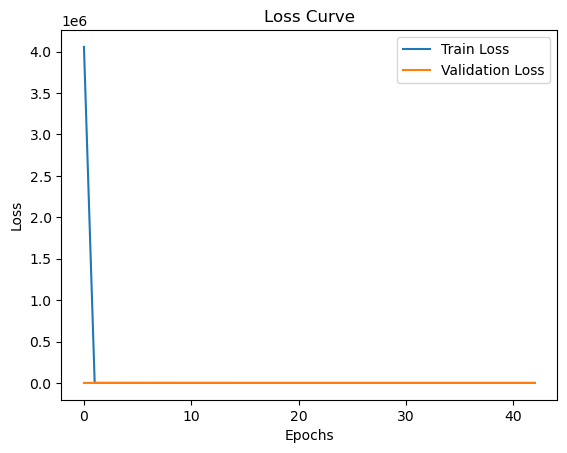

In [56]:
# Plot the loss curves for training and validation
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

### Bidirectional LSTM

In [57]:
n_steps = 72
n_features = 9

model = Sequential()
model.add(Masking(mask_value=0., input_shape=(n_steps, n_features)))

model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, activation = "relu", 
                             input_shape=(n_steps, n_features), return_sequences = True)))

model.add(LSTM(64, activation = "relu"))

model.add(Dense(62, activation = "relu"))
model.add(Dropout(0.3))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

/opt/homebrew/Caskroom/miniconda/base/envs/aiao-env/lib/python3.12/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/aiao-env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_5 (Masking)             │ (None, 72, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 72, 9)          │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 72, 128)        │        37,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 62)             │         4,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 62)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,425 (357.13 KB)

 Trainable params: 91,407 (357.06 KB)

 Non-trainable params: 18 (72.00 B)

In [58]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=5,          
                               restore_best_weights=True)  

# Fit the model
history = model.fit(X, Y, 
                    epochs=50, 
                    batch_size=1000, 
                    validation_split=0.3, 
                    callbacks=[early_stopping], 
                    verbose=1)

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 59s 475ms/step - loss: 1024.7625 - val_loss: 91.3118
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 68s 577ms/step - loss: 65.7088 - val_loss: 53.0723
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 73s 621ms/step - loss: 54.4564 - val_loss: 43.7420
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 70s 589ms/step - loss: 44.6869 - val_loss: 34.1146
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 73s 615ms/step - loss: 33.3241 - val_loss: 23.1395
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 72s 612ms/step - loss: 67.6353 - val_loss: 24.5445
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 70s 593ms/step - loss: 20.5764 - val_loss: 18.4303
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 75s 635ms/step - loss: 19.8521 - val_loss: 15.3030
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 73s 616ms/step - loss: 17.2591 - val_loss: 13.5347
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 73s 619ms/step - loss: 16.2213 - val_loss: 12.3508
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 73s 620ms/step - loss: 14.9684 - val_loss: 11.

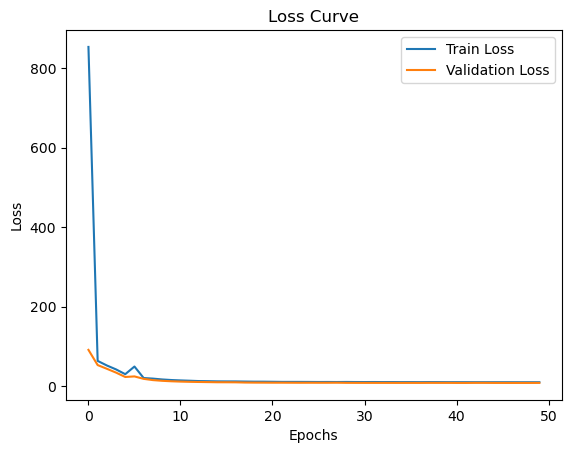

In [59]:
# Plot the loss curves for training and validation
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

### MUTLIVARIATE AND MULTISTEP

In [137]:
n_steps = 72
n_features = X.shape[2]
n_steps_out = 12

model = Sequential()
model.add(Masking(mask_value=-0.01, input_shape=(n_steps, n_features)))

model.add(BatchNormalization())
model.add(LSTM(128, activation = "relu", input_shape=(n_steps, n_features), return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(128, activation = "relu"))
model.add(Dropout(0.3))

model.add(Dense(n_steps_out))

model.compile(optimizer='adam', loss='mse')

model.summary()

/opt/homebrew/Caskroom/miniconda/base/envs/aiao-env/lib/python3.12/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/aiao-env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_18 (Masking)            │ (None, 72, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 72, 9)          │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 72, 128)        │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 72, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,824 (796.19 KB)

 Trainable params: 203,806 (796.12 KB)

 Non-trainable params: 18 (72.00 B)

In [138]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=5,          
                               restore_best_weights=True)  

# Fit the model
history = model.fit(X, Y, 
                    epochs=50, 
                    batch_size=1000, 
                    validation_split=0.3, 
                    callbacks=[early_stopping], 
                    verbose=1)

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 96s 797ms/step - loss: 0.0231 - val_loss: 0.0129
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 94s 796ms/step - loss: 0.0142 - val_loss: 0.0121
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 94s 795ms/step - loss: 0.0233 - val_loss: 0.0121
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 93s 790ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 99s 839ms/step - loss: 1.1546 - val_loss: 0.0112
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 95s 805ms/step - loss: 0.0123 - val_loss: 0.0104
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 95s 803ms/step - loss: 0.0111 - val_loss: 0.0108
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 96s 818ms/step - loss: 0.0105 - val_loss: 0.0104
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 94s 799ms/step - loss: 0.0102 - val_loss: 0.0104
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 95s 808ms/step - loss: 0.0099 - val_loss: 0.0102
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 93s 791ms/step - loss: 0.0097 - val_loss: 60014284.0000
Epoch 12/50


## Encoder decoder

In [76]:
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(n_steps, n_features)))

model.add(BatchNormalization())
model.add(LSTM(128, activation = "relu", input_shape=(n_steps, n_features)))
model.add(Dropout(0.3))
model.add(RepeatVector(n_steps_out))

model.add(LSTM(128, activation = "relu", return_sequences = True))
model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(1)))

model.compile(optimizer='adam', loss='mse')

model.summary()

/opt/homebrew/Caskroom/miniconda/base/envs/aiao-env/lib/python3.12/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/aiao-env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_11 (Masking)            │ (None, 72, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 72, 9)          │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 128)            │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 12, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 12, 1)          │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,405 (790.64 KB)

 Trainable params: 202,387 (790.57 KB)

 Non-trainable params: 18 (72.00 B)

In [77]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=5,          
                               restore_best_weights=True)  

# Fit the model
history = model.fit(X, Y, 
                    epochs=50, 
                    batch_size=1000, 
                    validation_split=0.3, 
                    callbacks=[early_stopping], 
                    verbose=1)

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 52s 422ms/step - loss: 777.5392 - val_loss: 15854112.0000
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 47s 400ms/step - loss: 11.5617 - val_loss: 8.1016
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 47s 395ms/step - loss: 9.8461 - val_loss: 7.9811
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 48s 407ms/step - loss: 9.7341 - val_loss: 7.9015
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 48s 408ms/step - loss: 9.6652 - val_loss: 7.9557
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 48s 407ms/step - loss: 9.5762 - val_loss: 8.1321
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 48s 409ms/step - loss: 9.4654 - val_loss: 7.9381
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 48s 403ms/step - loss: 9.3873 - val_loss: 8.9979
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 47s 402ms/step - loss: 9.6610 - val_loss: 7.9676


##